In [25]:
# BLOCK 1: Imports + Load Data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Load your cleaned dataset
df = pd.read_csv("salaries_cyber_clean.csv")

df.head()


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2022,EN,FT,CYBER PROGRAM MANAGER,63000,USD,63000.0,US,50,US,S
1,2022,MI,FT,SECURITY ANALYST,95000,USD,95000.0,US,0,US,M
2,2022,MI,FT,SECURITY ANALYST,70000,USD,70000.0,US,0,US,M
3,2022,MI,FT,IT SECURITY ANALYST,250000,BRL,48853.0,BR,50,BR,L
4,2022,EN,CT,CYBER SECURITY ANALYST,120000,USD,120000.0,BW,100,BW,S


In [26]:
# BLOCK 2: Define features and target (LOG salary)

# Categorical features
categorical_features = [
    'job_title',
    'experience_level',
    'employment_type',
    'company_location',
    'company_size',
    'employee_residence'
]

# Numeric features
numeric_features = ['remote_ratio']

# Full feature list
features = categorical_features + numeric_features

# Define X and y
X = df[features].copy()

# LOG target for more stable regression
y = np.log1p(df['salary_in_usd'])

X.dtypes, y.head()


(job_title             object
 experience_level      object
 employment_type       object
 company_location      object
 company_size          object
 employee_residence    object
 remote_ratio           int64
 dtype: object,
 0    11.050906
 1    11.461643
 2    11.156265
 3    10.796592
 4    11.695255
 Name: salary_in_usd, dtype: float64)

In [27]:
# BLOCK 3: Preprocessor with OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)


In [28]:
# BLOCK 4: Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape


((929, 7), (233, 7))

In [29]:
# BLOCK 5: Linear Regression model (with preprocessing pipeline)

lr_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)

lr_mse = mean_squared_error(y_test, lr_pred)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, lr_pred)

print("Linear Regression (OneHot + log target)")
print(f"  MSE:  {lr_mse:.6f}")
print(f"  RMSE: {lr_rmse:.6f}")
print(f"  R²:   {lr_r2:.6f}")


Linear Regression (OneHot + log target)
  MSE:  0.242385
  RMSE: 0.492327
  R²:   0.421896


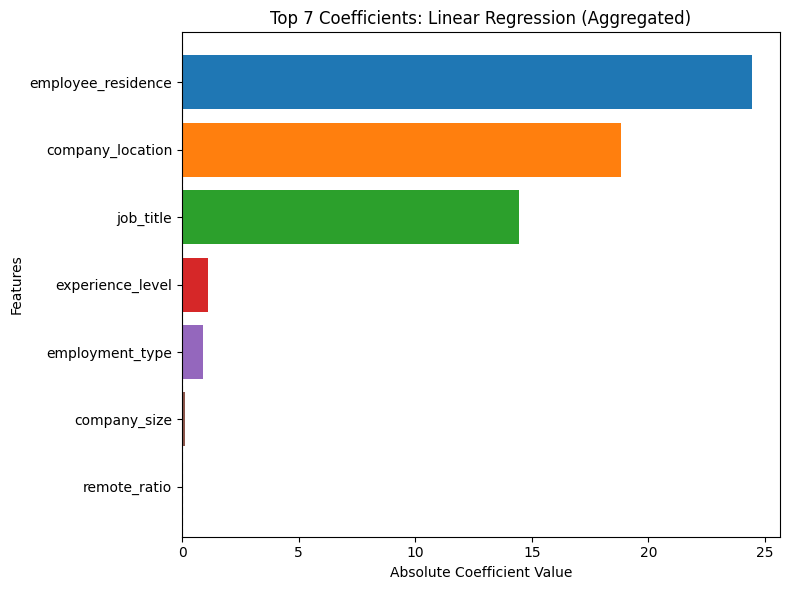

In [ ]:
# BLOCK 6:Linear Regression Coefficient Plot (Aggregated to 7 original features)

# 0. Extract the trained LR model inside your pipeline
lr_model = lr_pipeline.named_steps['model']

# 1. Extract OHE names
ohe = lr_pipeline.named_steps['preprocess'].named_transformers_['cat']
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))

# 2. Full list of encoded feature names
full_names = ohe_feature_names + numeric_features

# 3. Get raw coefficients for encoded columns
raw_coefs = lr_model.coef_

# 4. Aggregate coefficients back to original features
agg_coef = {}

# categorical = sum absolute coefficient values of all encoded columns
for f in categorical_features:
    idxs = [i for i, name in enumerate(full_names) if name.startswith(f)]
    agg_coef[f] = np.sum(np.abs(raw_coefs[idxs]))

# numeric = absolute coefficient directly
for f in numeric_features:
    idx = full_names.index(f)
    agg_coef[f] = abs(raw_coefs[idx])

# 5. Sort and pick top 7
sorted_items = sorted(agg_coef.items(), key=lambda x: x[1], reverse=True)[:7]
top_features = [x[0] for x in sorted_items]
top_coefs = [x[1] for x in sorted_items]

# 6. Plot
colors = sns.color_palette('tab10', len(top_features))
plt.figure(figsize=(8, 6))
plt.barh(top_features[::-1], top_coefs[::-1], color=colors[::-1])
plt.title('Top 7 Coefficients: Linear Regression (Aggregated)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Features')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


In [ ]:
# BLOCK 7: Random Forest model (with preprocessing pipeline)

rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest (OneHot + log target)")
print(f"  MSE:  {rf_mse:.6f}")
print(f"  RMSE: {rf_rmse:.6f}")
print(f"  R²:   {rf_r2:.6f}")


Random Forest (OneHot + log target)
  MSE:  0.198034
  RMSE: 0.445010
  R²:   0.527677


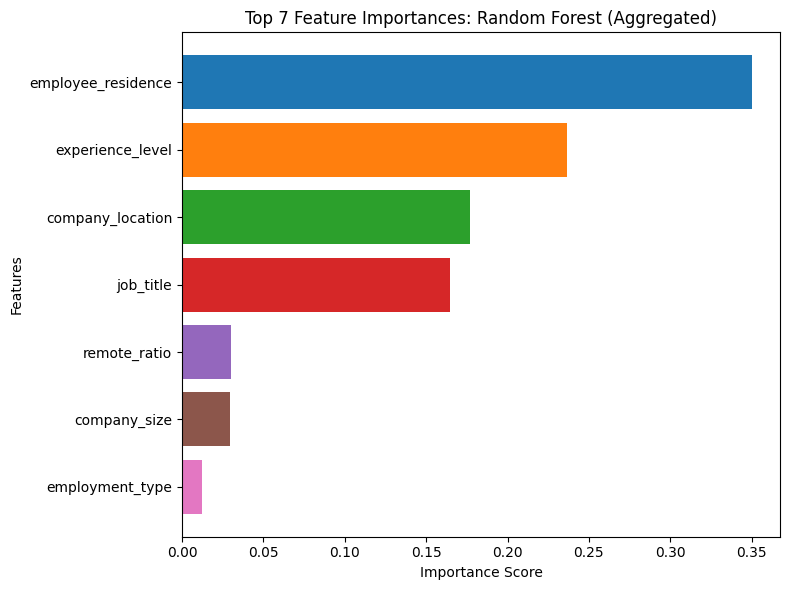

In [ ]:
# BLOCK 8: Random Forest Feature Importances (Aggregated to 7 original features)

# 0. Extract trained RF model inside pipeline
rf_model = rf_pipeline.named_steps["model"]

# 1. Extract OHE names from preprocessor
ohe = rf_pipeline.named_steps["preprocess"].named_transformers_['cat']
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))

# 2. Full list of encoded feature names
full_names = ohe_feature_names + numeric_features

# 3. Raw importances for encoded columns
raw_importances = rf_model.feature_importances_

# 4. Aggregate importances back into original feature groups
agg_importance = {}

# categorical features: sum all dummy columns
for f in categorical_features:
    idxs = [i for i, name in enumerate(full_names) if name.startswith(f)]
    agg_importance[f] = raw_importances[idxs].sum()

# numeric features: direct
for f in numeric_features:
    idx = full_names.index(f)
    agg_importance[f] = raw_importances[idx]

# 5. Sort top 7
sorted_items = sorted(agg_importance.items(), key=lambda x: x[1], reverse=True)[:7]
top_features = [x[0] for x in sorted_items]
top_importances = [x[1] for x in sorted_items]

# 6. Plot top 7 (same style as your code)
colors = sns.color_palette('tab10', len(top_features))
plt.figure(figsize=(8, 6))
plt.barh(top_features[::-1], top_importances[::-1], color=colors[::-1])
plt.title('Top 7 Feature Importances: Random Forest (Aggregated)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [ ]:
# BLOCK 9: XGBoost model (with preprocessing pipeline)

xgb_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', XGBRegressor(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='reg:squarederror',
        n_jobs=-1
    ))
])

xgb_pipeline.fit(X_train, y_train)
xgb_pred = xgb_pipeline.predict(X_test)

xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_pred)

print("XGBoost (OneHot + log target)")
print(f"  MSE:  {xgb_mse:.6f}")
print(f"  RMSE: {xgb_rmse:.6f}")
print(f"  R²:   {xgb_r2:.6f}")


XGBoost (OneHot + log target)
  MSE:  0.206423
  RMSE: 0.454338
  R²:   0.507668


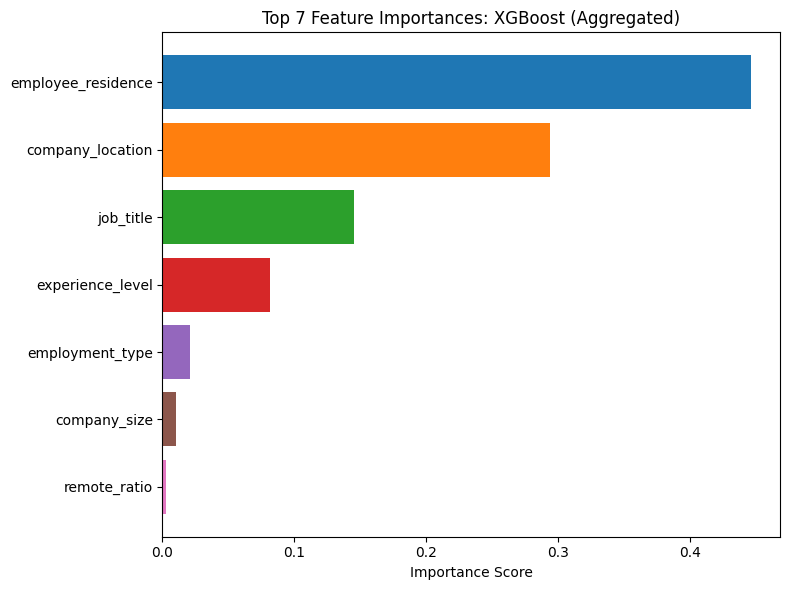

In [ ]:
# BLOCK 10: XGBoost Feature Importances

# 0. Transform using your preprocessor first
X_train_enc = preprocessor.fit_transform(X_train)
X_test_enc = preprocessor.transform(X_test)

# 1. Train XGBoost
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    verbosity=0
)
xgb_model.fit(X_train_enc, y_train)
xgb_pred = xgb_model.predict(X_test_enc)

# 2. Raw importances (for encoded columns)
raw_importances = xgb_model.feature_importances_

# 3. Get encoded feature names
ohe = preprocessor.named_transformers_['cat']
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
full_names = ohe_feature_names + numeric_features

# 4. Aggregate back to original 7 features
agg_importance = {}

for f in categorical_features:
    idxs = [i for i, name in enumerate(full_names) if name.startswith(f)]
    agg_importance[f] = raw_importances[idxs].sum()

for f in numeric_features:
    idx = full_names.index(f)
    agg_importance[f] = raw_importances[idx]

# 5. Sort top 7
sorted_items = sorted(agg_importance.items(), key=lambda x: x[1], reverse=True)[:7]
top_features = [x[0] for x in sorted_items]
top_importances = [x[1] for x in sorted_items]

# 6. Plot
colors = sns.color_palette('tab10', len(top_features))
plt.figure(figsize=(8, 6))
plt.barh(top_features[::-1], top_importances[::-1], color=colors[::-1])
plt.title('Top 7 Feature Importances: XGBoost (Aggregated)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


In [ ]:
# BLOCK 11: Compare models

results = [
    {"Model": "Linear Regression", "MSE": lr_mse, "RMSE": lr_rmse, "R²": lr_r2},
    {"Model": "Random Forest",    "MSE": rf_mse, "RMSE": rf_rmse, "R²": rf_r2},
    {"Model": "XGBoost",          "MSE": xgb_mse, "RMSE": xgb_rmse, "R²": xgb_r2},
]

results_df = pd.DataFrame(results)
results_df


,Model,MSE,RMSE,R²
0,Linear Regression,0.242385,0.492327,0.421896
1,Random Forest,0.198034,0.445010,0.527677
2,XGBoost,0.206423,0.454338,0.507668
